In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem


Clean up the data
 - clear up non values
 - dropping zero-variance features and similar features

In [101]:
#Data loading
dft_source = pd.read_excel('allligands_dft_data_210125.xlsx', engine = 'openpyxl', sheet_name = "allligands_dft_data_210125")

In [102]:
#Preparing to match dft data to ligands we use in smc
#Turing smiles from smc to inchi
smc_df = pd.read_excel('smc_data.xlsx', engine = 'openpyxl', sheet_name='SMC')
#smc_inchi = smc_df['Smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

In [103]:
#Turning smiles from dft_source to inchi
#dft_source_inchi = dft_source['Smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

smc_dft_df = pd.read_excel('smc_data.xlsx', engine = 'openpyxl', sheet_name='DFT_SMC')
smc_dft_df = dft_source.loc[dft_source['ID'].isin(smc_df['Kraken ID#'])]
smc_dft_df.fillna(0)
df = smc_dft_df.drop(columns = 'SMILES')

In [104]:
from sklearn.preprocessing import scale
# standardize
df=pd.DataFrame(scale(df),index=df.index, columns=df.columns)
# drop zero-variance features
zero_std_cols = df.columns[df.std() == 0]
df=df[df.columns.difference(zero_std_cols)]

In [105]:
print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

Dropping 2 features Index(['x122', 'x125'], dtype='object')


In [106]:
# drop highly correlated features
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 78 features ['ID.1', 'ID.2', 'x100', 'x107', 'x108', 'x110', 'x111', 'x112', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x124', 'x130', 'x133', 'x134', 'x135', 'x137', 'x138', 'x14', 'x140', 'x142', 'x145', 'x146', 'x147', 'x150', 'x152', 'x153', 'x155', 'x159', 'x160', 'x168', 'x192', 'x22', 'x29', 'x4', 'x41', 'x42', 'x48', 'x49', 'x61', 'x62', 'x63', 'x64', 'x65', 'x69', 'x7', 'x71', 'x72', 'x73', 'x74', 'x75', 'x78', 'x8', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x96', 'x97', 'x98', 'x99', 'y15', 'y16', 'y18', 'y19', 'y5', 'y7', 'y8', 'y9']


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
#Arbitrarily assign 0 value to all NaN spaces
df.replace(np.nan, 0)
#Dropping some of the incomplete/useless parts of dataset
try:
    df = df.drop(columns = ['ID','Unnamed: 110','y1','y2','y3','y4','buch'])
    df = df.drop(columns = ['y6','y10','y11','y12','y13','y14','y17'])
    df = df.drop(columns = ['y15','y16','y18','y19','y5','y7','y8','y9'])
except:
    pass



In [108]:
#shuffle dataframe
from sklearn.utils import shuffle
df = shuffle(df,random_state=1)
N = 50
df = df.iloc[: , :N]
print(df)
df.to_excel("output.xlsx")  

     179.59438003021648        x1       x10      x101      x102      x103  \
270            2.868306 -1.119219  0.122885 -0.318118  0.124656 -0.667025   
548           -0.632520  0.090366  0.251652  4.126934  4.207760  3.747587   
177           -0.598633  0.043056  0.189042  1.179442  1.053277  1.023961   
247           -0.173576 -0.095258 -1.117218 -1.005226 -1.193972 -0.560829   
740           -0.514083  2.352265  0.838654  0.710086  1.059394  0.261727   
..                  ...       ...       ...       ...       ...       ...   
333            2.741176 -0.383607  0.976283  1.350758  1.742512  0.868146   
20            -0.953944 -0.593422 -1.324723 -1.631037 -1.336494 -1.727124   
316            2.183624 -0.265062 -0.257236 -0.362312  0.087353 -0.709289   
31            -0.064918 -0.979975 -0.342224 -0.660468 -0.288471 -0.655927   
165           -0.820499 -0.140273 -0.055534  0.166701 -0.226694  0.613521   

         x104      x105      x106      x109  ...      x123      x126  \
270

UMAP Dimension Reduction to 2

In [109]:
from sklearn.decomposition import PCA
from umap import UMAP
# define the dimensionalities of the reduced representation to study
dims = [80, 50, 20, 10, 5, 2]
# dictionary to store data at different levels of dimensionality reduction
dfs={}
# UMAP section
n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=0).fit_transform(df), index=df.index)
# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(df), index=df.index)
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


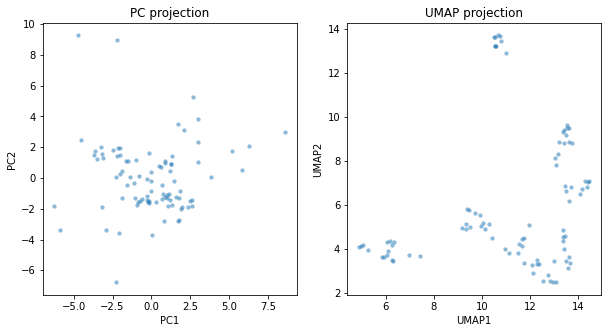

In [110]:
# Visualize the embeddings
f, ax = plt.subplots(1, 2, figsize=(10, 5)) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
_= sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=0.5, linewidth=0.25,  edgecolor='face', ax=ax[0]).set_title("PC projection")
_=sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=0.5, linewidth=0.25, edgecolor='face', ax=ax[1]).set_title("UMAP projection")

Clustering

In [111]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn.metrics import silhouette_score
# Define the numbeor of clusters to study
N_CLS_list = list(range(5, 41))
def silhouette_scores_hierarchical(data, n_cls_list):
 """helper function to compute a silhouette score for hierarchical cluster
ing using Ward linkage"""
 
 z = linkage(data, method='ward')
 
 result = pd.Series(index=n_cls_list, dtype=float)
 for n_cls in n_cls_list:
    cls = fcluster(z, n_cls, criterion='maxclust')
    result.loc[n_cls] = silhouette_score(data, cls)
 return result


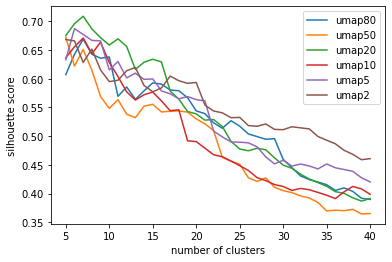

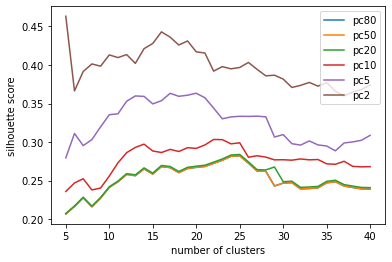

In [112]:
# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)
# plot the silhouette scores
_=silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(
xlabel='number of clusters',ylabel='silhouette score')


Final Clustering

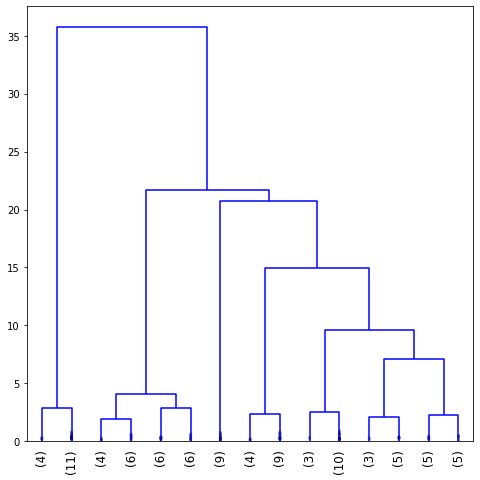

In [113]:
# final number of clusters to produce
NCLS = 15
# linkage and clustering for selected featurization
z = linkage(dfs['umap10'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')
# plot the dendrogram
plt.figure(figsize=(8, 8))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True, leaf_rotation=90, color_threshold=0)


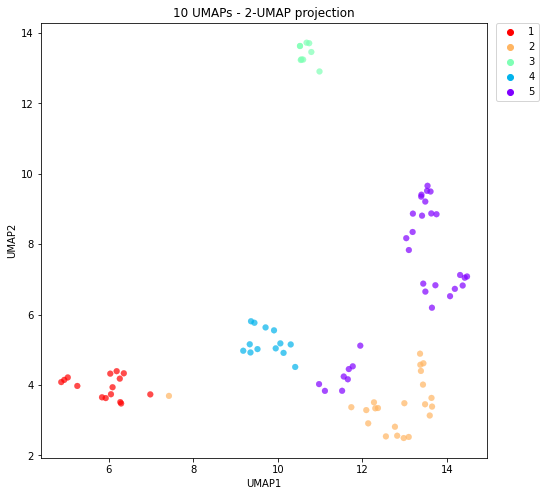

In [114]:
# plot clustering
NCLS = 5
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


In [115]:
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    rxns = []
    smiles = df['SMILES']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns

Cluster 1, n molecules: 15


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


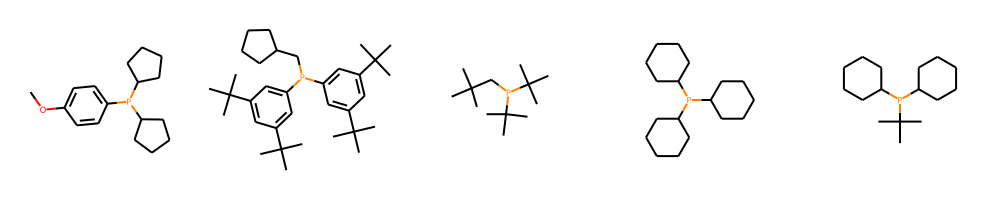

Cluster 2, n molecules: 22


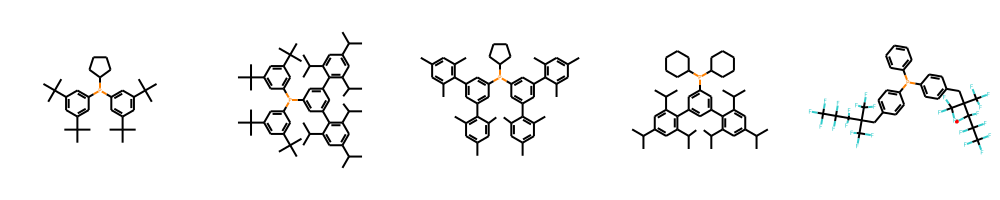

Cluster 3, n molecules: 9


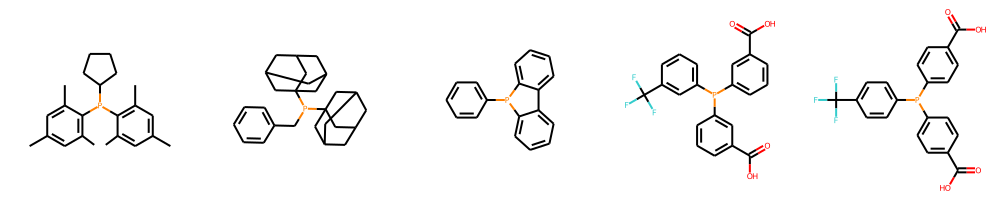

Cluster 4, n molecules: 13


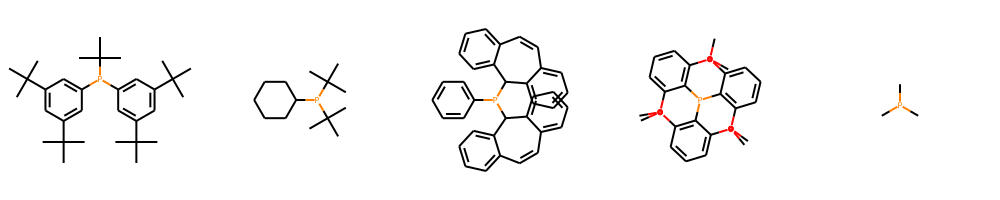

Cluster 5, n molecules: 31


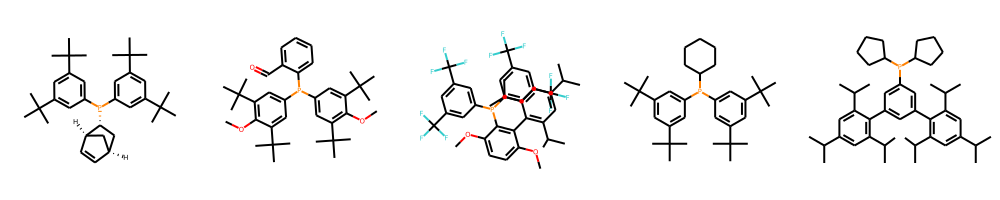

In [116]:
from scipy.spatial.distance import cdist
from rdkit.Chem import Draw
# build rdkit molecules for all candidates
df = smc_dft_df
df['mol'] = generate_ligand_data(df)
mols = pd.Series(((df['mol'])), index=df.index).to_frame('mol')
features='umap2'
# How many central molecules to display?
n_per_cluster = 5
# store central candidates for 
cands=[]
for group, data in mols.groupby(cls):
 # get descriptor data for this cluster
 desc_data=dfs[features].loc[data.index]
 
 # compute distances of these molecules to their center
 dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
 index=desc_data.index)
 # select top n central molecules
 selected=dists.sort_values().head(n_per_cluster).index
 
 smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
 smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
 cands.append(smi)
 
 print (f"Cluster {group}, n molecules: {len(data)}")
 ms = data['mol'].loc[selected]
 display(Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster))
 
cands = pd.concat(cands, axis=1)